# LC3 DATA ANALYSIS

In this notebook we analize the relation of the compressive strength of LC3 with the clay used for its elaboration properties.

### Load libraries and data

In [1]:
# Libraries for general data management
import pandas as pd
import numpy  as np

In [2]:
# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score

In [3]:
# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

In [4]:
# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [5]:
# Read data skipping the first row and considering also '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

In [6]:
# We rename some columns for having an easier reference
data.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)

data.rename(columns = {'STD'  : 'STD_1D'}, inplace = True)
data.rename(columns = {'STD.1': 'STD_3D'}, inplace = True)
data.rename(columns = {'STD.2': 'STD_7D'}, inplace = True)
data.rename(columns = {'STD.3':'STD_28D'}, inplace = True)
data.rename(columns = {'STD.4':'STD_90D'}, inplace = True)

# Sorting allows us to plot functions more easily
data = data.sort_values('Kaolinite_content')

# Get useful dataframe information
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

### Visualize data

In [7]:
# Take kaolinite content
x = data['Kaolinite_content'].values 

# Take compression strengths
y1  = data[ "1D"].values
y3  = data[ "3D"].values
y7  = data[ "7D"].values
y28 = data["28D"].values
y90 = data["90D"].values

# Measures at 90 days have missing values (4 in total)
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values

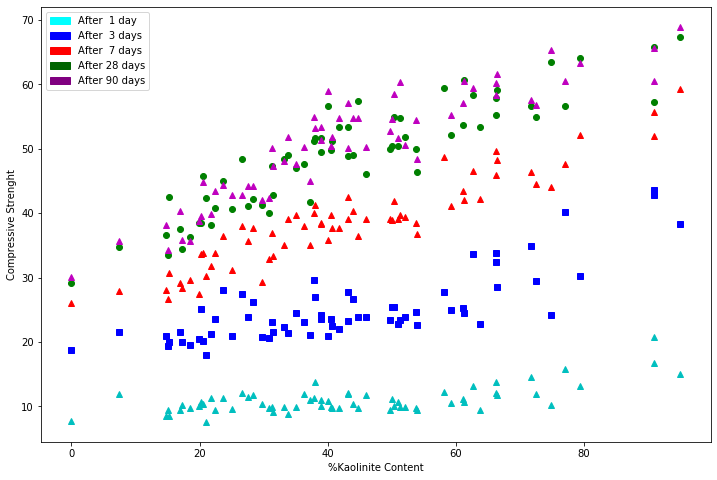

In [8]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x,y1,'c^',x,y3,'bs',x,y7,'r^',x,y28,'go', x90,y90,'m^')
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

**First sight analysis:**

* **CS Day 1:** Almost constant, it curves from kaolinite content 50%, try degree two feature expansion.
* **CS Day 3:** Sparse points, we need to add another feature and maybe try also feature expansion.
* **CS Day 7:** The straight line is quite clear, we can try adding another feature for avoiding sparsification.
* **CS Day 28:** Straight line until 40% kaolinite content, then it curves. Feature expansion is needed as well as another feature for reducing sparsification.
* **CS Day 90:** Totally analogous than the day 28 data.


**Observations and next steps:**
* Maybe it would be interesting to have a predictor of the compression strength at 90 days (at time=infinity) knowing the compression strength before.
* In feature augmentation never go further than degree two, the curve is clearly always increasing.
* When having models involving only one or two features it's going to be important to plot for checking correctness.
* We have to search also mathematical measurements for the correctness of our models.

### Data correlation analysis

We have measures of 21 features/properties of the clays. Which are the (cor)relations among them? Which are the most important for predicting the compression strength? Are there redundancies?  We first try to answer this question by analyzing the correlations.

In [9]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [10]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.6

corr_matrix = data.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

,Kaolinite_content,Dv50,D10,D90,Span (-),BET_specific_surface,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
Kaolinite_content,1.000000,-0.193017,-0.305015,-0.244189,0.084664,0.089423,-0.660779,0.916209,-0.254266,-0.202572,-0.338773,0.016628,-0.200614,-0.411239,0.414770,-0.035480,0.316228,0.024821,0.231897
Dv50,-0.193017,1.000000,0.451829,0.776255,0.119163,-0.015583,0.287292,-0.242921,-0.189271,0.042118,0.052258,0.077456,-0.096222,0.074709,-0.006009,0.385650,0.255514,-0.084343,-0.230361
D10,-0.305015,0.451829,1.000000,-0.035547,-0.436280,-0.404479,0.382222,-0.145179,-0.431953,-0.214363,-0.187739,0.225985,0.012912,0.618675,-0.589368,0.378885,-0.771972,-0.200548,-0.064193
D90,-0.244189,0.776255,-0.035547,1.000000,0.736569,-0.089815,0.193764,-0.340139,-0.028480,0.342000,0.365395,0.975371,-0.132507,0.047146,-0.043585,0.138796,-0.142464,-0.011756,-0.171109
Span (-),0.084664,0.119163,-0.436280,0.736569,1.000000,0.101806,-0.072553,-0.042011,0.082441,0.072997,-0.075898,0.033117,-0.094787,-0.161342,0.197525,-0.029135,0.115944,-0.168370,-0.043502
BET_specific_surface,0.089423,-0.015583,-0.404479,-0.089815,0.101806,1.000000,-0.421059,0.052440,0.619421,-0.100527,0.147891,-0.151082,-0.016290,-0.183056,0.099011,-0.142684,0.643980,-0.342051,0.152745
SiO2,-0.660779,0.287292,0.382222,0.193764,-0.072553,-0.421059,1.000000,-0.725183,-0.364198,-0.108063,-0.181542,-0.208559,-0.144506,0.130411,-0.410854,-0.038594,-0.305488,0.057821,-0.390461
Al2O3,0.916209,-0.242921,-0.145179,-0.340139,-0.042011,0.052440,-0.725183,1.000000,-0.282481,-0.211962,-0.286575,-0.169586,-0.213801,-0.315134,0.369314,-0.051612,0.372933,-0.036482,0.308423
Fe2O3,-0.254266,-0.189271,-0.431953,-0.028480,0.082441,0.619421,-0.364198,-0.282481,1.000000,0.004174,0.231275,0.008352,0.158245,-0.114540,0.208177,0.095215,0.104339,-0.108749,-0.060084
CaO,-0.202572,0.042118,-0.214363,0.342000,0.072997,-0.100527,-0.108063,-0.211962,0.004174,1.000000,0.569413,0.625109,0.496111,-0.086462,-0.304487,-0.135553,-0.081563,0.128110,0.067826


In [12]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.65

corr_matrix = data.corr()[10:].iloc[:, [0,2,4,6,8]]
corr_matrix.style.applymap(highlight_high_correlations)

,1D,3D,7D,28D,90D
Kaolinite_content,0.658071,0.781898,0.930966,0.900876,0.911653
Dv50,-0.111246,-0.011320,-0.116061,-0.146193,-0.152193
D10,-0.274278,-0.351558,-0.296297,-0.287737,-0.290692
D90,-0.225330,-0.169381,-0.147715,-0.131897,-0.141472
Span (-),-0.008618,0.096408,0.176071,0.178734,0.099044
BET_specific_surface,-0.077832,-0.032558,0.083831,0.108786,0.198791
SiO2,-0.430950,-0.443933,-0.563664,-0.579837,-0.635442
Al2O3,0.614406,0.705345,0.834569,0.809226,0.845753
Fe2O3,-0.268702,-0.284461,-0.265054,-0.259344,-0.242389
CaO,-0.171936,-0.143753,-0.217687,-0.181013,-0.136114


In [13]:
# Correlation between standard deviations of measurements and clays properties
CORRELATION_THRESHOLD = 0.2

corr_matrix = data.corr()[10:].iloc[:, [1,3,5,7,9]]
corr_matrix.style.applymap(highlight_high_correlations)

,STD_1D,STD_3D,STD_7D,STD_28D,STD_90D
Kaolinite_content,0.098020,0.462649,0.183329,0.358627,0.191225
Dv50,-0.118125,-0.129720,-0.113932,-0.185816,-0.105022
D10,-0.159055,-0.401368,-0.215840,-0.224444,-0.245231
D90,-0.018398,-0.070994,-0.032689,-0.082954,0.184129
Span (-),0.020704,0.055594,0.044010,0.022846,0.143911
BET_specific_surface,-0.345532,0.010624,-0.092784,0.131376,-0.059141
SiO2,0.006149,-0.302855,-0.086754,-0.322744,-0.080277
Al2O3,0.029920,0.394946,0.248389,0.322680,0.106657
Fe2O3,-0.137893,-0.100728,-0.108874,0.004947,0.019647
CaO,0.140246,0.012872,-0.146547,-0.101726,0.134408


**First sight analysis:**

* Several important correlations between features, be aware of this when chosing features for our model to avoid redundancy.
* Compression strength can be predicted quite good with only the Kaolinite content, the relation is clear.
* At first sight there is no clear evidence of any feature being behind the standard deviation/variability of lc3.

# COMPRESSION STRENGTH (CS)

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

In [21]:
# TODO: Remove outlier in y1 data?
# TODO: Idea for the report, removing pesimist outliers is not a good idea in our project!
# TODO: Add OPC compression strength values for reference

#### Linear models based on the kaolinite content

In [22]:
# Create, estimate, validate and show the model
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X, np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X, y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Model and metrics
    print('f(x) = {0} + {1}*x'.format(model.intercept_, model.coef_[0]))
    print()
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

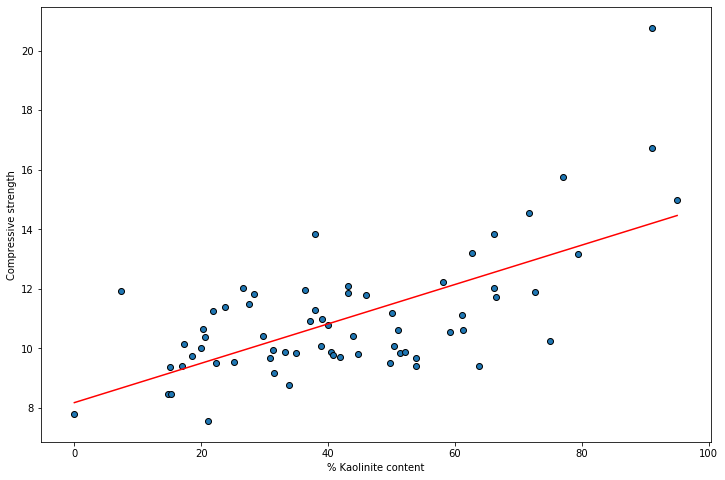

f(x) = 8.182078798084477 + 0.06610392732898104*x

MSE: 2.8317285562269334
R^2: 0.4330574737902103


In [23]:
leave_one_out_validation(x.reshape(-1,1), y1)

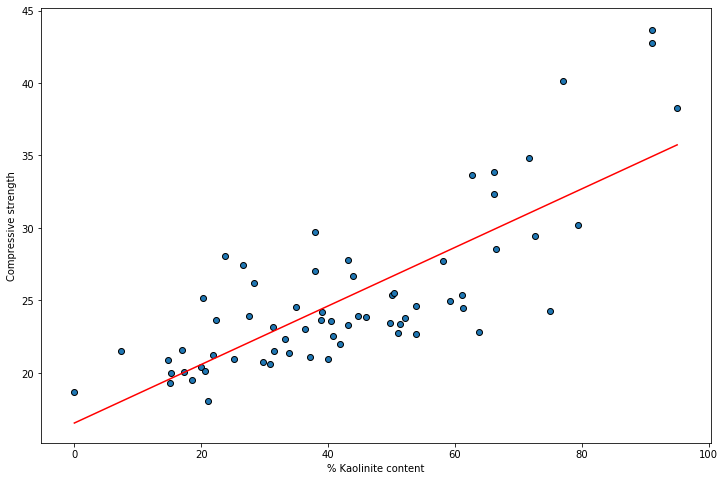

f(x) = 16.544774345389964 + 0.20197895450867684*x

MSE: 12.675898171489054
R^2: 0.6113650603318864


In [24]:
leave_one_out_validation(x.reshape(-1,1), y3)

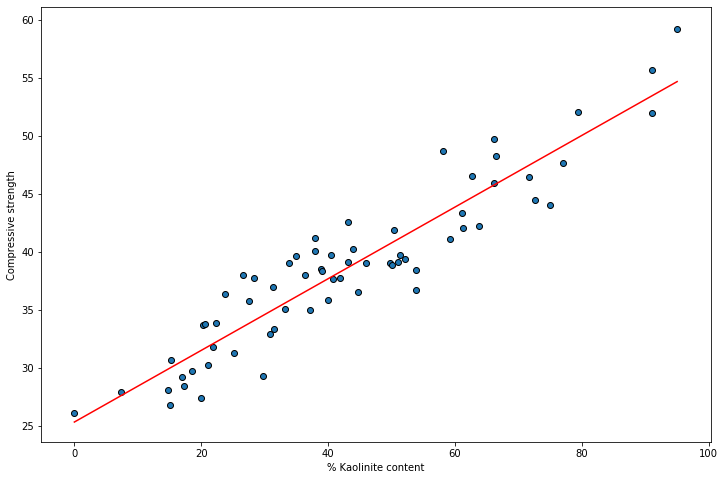

f(x) = 25.30760246706364 + 0.30925338626977783*x

MSE: 7.003924552940119
R^2: 0.8666969837714468


In [25]:
leave_one_out_validation(x.reshape(-1,1), y7)

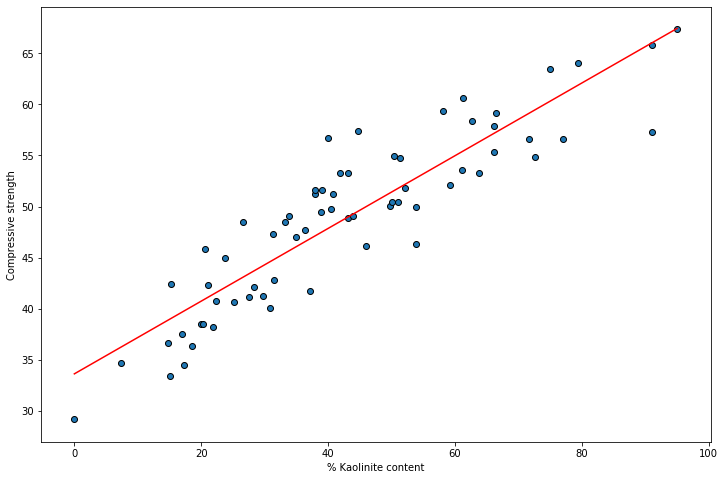

f(x) = 33.62781210162508 + 0.3558471318971575*x

MSE: 14.03120897751386
R^2: 0.8115769970840359


In [26]:
leave_one_out_validation(x.reshape(-1,1), y28)

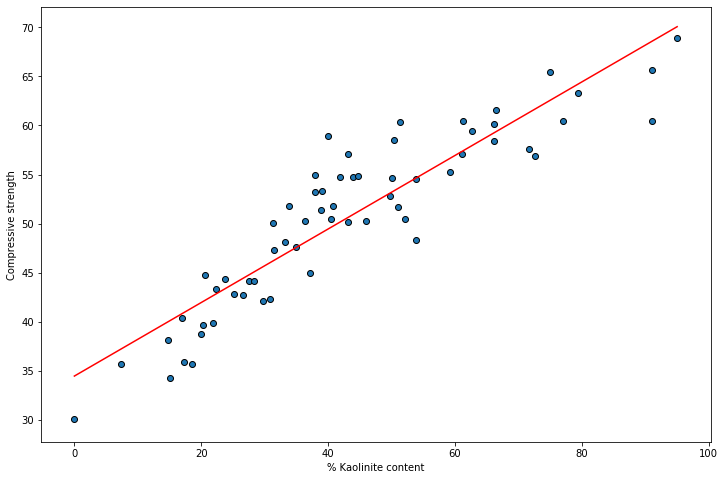

f(x) = 34.473502265715304 + 0.3745752546931824*x

MSE: 13.593520931397062
R^2: 0.8311103650575946


In [27]:
leave_one_out_validation(x90.reshape(-1,1), y90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite linear.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [28]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x_2   = np.array([x, x**2]).T
x90_2 = np.array([x90,x90*x90]).T 

In [29]:
# Same function than before but adapted for degree two case
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train and show the model
    model.fit(X, y) 
    
    # This could be generalized but degree n >= 3 leads to overfitting!
    print('f(x) = {0} + {1}*x + {2}*x^2'.format(model.intercept_, model.coef_[0], model.coef_[1]))
        
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Metrics for the model
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

f(x) = 10.484771154982107 + -0.055615734871761954*x + 0.0012762473993578134*x^2


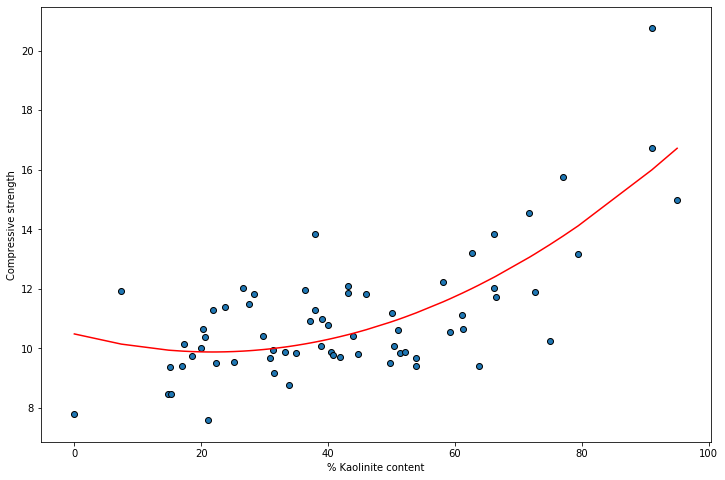

MSE: 2.5126547736924403
R^2: 0.5395335354132511


In [30]:
leave_one_out_validation(x_2, y1)

f(x) = 21.86829736398526 + -0.07942095616558521*x + 0.002950516766841272*x^2


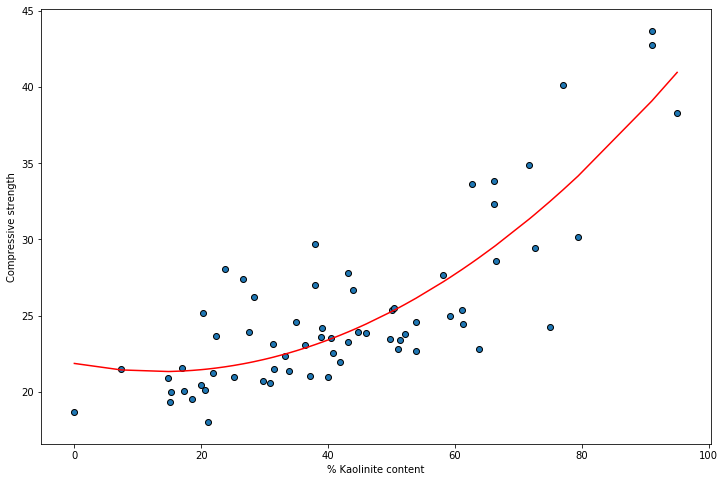

MSE: 10.154742232922898
R^2: 0.6974199940372013


In [31]:
leave_one_out_validation(x_2, y3)

f(x) = 25.82211635397165 + 0.2820563287364778*x + 0.0002851648888888165*x^2


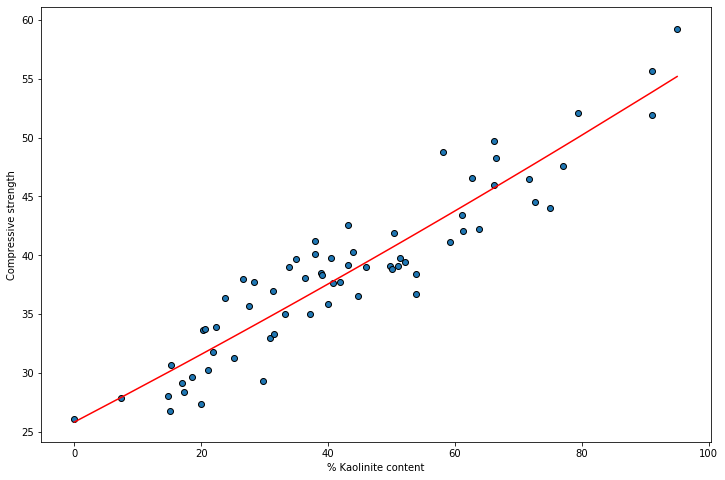

MSE: 7.226290975440004
R^2: 0.8671830793671289


In [32]:
leave_one_out_validation(x_2, y7)

f(x) = 29.328626511860694 + 0.5831008578049675*x + -0.0023827865723607413*x^2


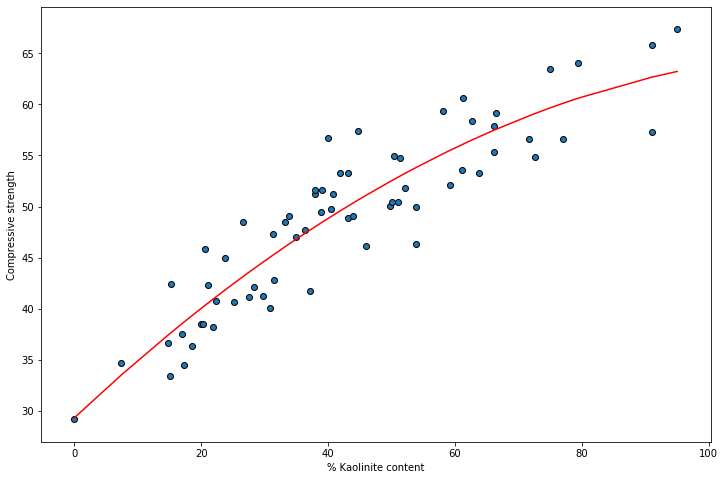

MSE: 12.724683642602642
R^2: 0.8355799295281007


In [33]:
leave_one_out_validation(x_2, y28)

f(x) = 28.410982110532352 + 0.6895682753822581*x + -0.003263615026661798*x^2


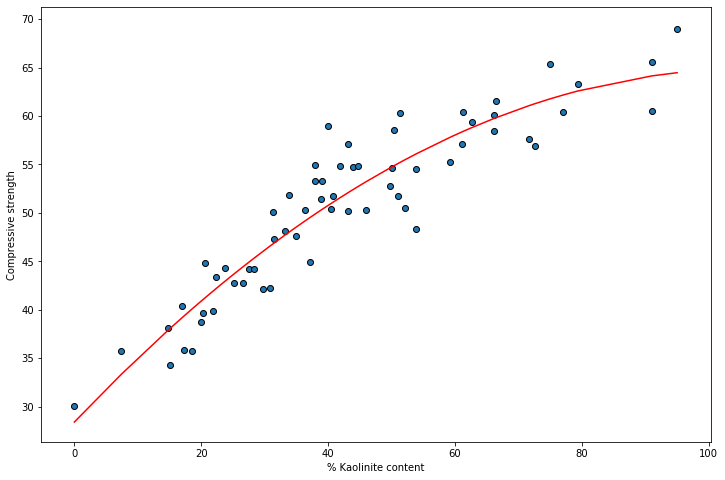

MSE: 10.517834018934327
R^2: 0.874207873018347


In [34]:
leave_one_out_validation(x90_2, y90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compression strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

### Feature selection

We have seen the importance and the clear relation of the Kaolinite conent with the compression strength and, we have seen also that the models involving only kaolinite content have their limitations (because of data sparsification). For achieving better results we have to add more modelation expressiveness by adding other variables to our model (new features or other artificially created) and, since the data distribution makes us think that linear regression models with the kaolinite content in degree three or more lead to overfitting, the best choice is adding new features.

Again, for avoiding overfitting with the few data we have we can't add several features so we have to decide well which is the best feature for complementing the kaolinite content. That's is the question we try to solve in this part.

In [14]:
# Which features are realiable? Those with more than RELIABLE_THRESHOLD measurements
RELIABLE_THRESHOLD = 45

features = data.columns[14:]
reliable_features = [f for f in features if data[f].describe()[0] >= RELIABLE_THRESHOLD]

In [16]:
# Show the reliable features, with enough points to rely
# reliable_features

In [17]:
# Function to return the R2 and validation score for a model (linear regression by default)
def model_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Return the metrics
    return model.score(X,y), mean_squared_error(y, predicted)

In [18]:
# TODO: We are computing metrics for every feature, why not building a matrix with all te information?
# TODO: model.score(X,y) returns R^2, should we try to get Adj R^2?

# Function to perform feature selection from those given as parameter. It choses those
# features that better complements kaolinite content for achieving the best R2 and MSE.
def feature_selection(features, days=[1,3,7,28,90]):
    # For every day we want to do feature selection
    for i in days:    
        day = str(i) + 'D'
        bestR2  = -1 
        bestMse = float('inf')
        
        # Go for every feature given and check wich results we get with it
        for feature in features:
            # IMPORTANT! Metrics can cheat us if we drop NaNs!!
            # IMPORTANT! That's what we have to rely the features we are testing!!
            df = data[['Kaolinite_content', feature, day]].dropna()
            df['Kaolinite_content_square'] = (df['Kaolinite_content'].values)**2
            
            # Kaolinite content is always in our features in degree one and two
            X = df[['Kaolinite_content', 'Kaolinite_content_square', feature]].values
            y = df[day].values
        
            # Get the metrics
            r2, mse = model_validation(X,y)
            
            # Keep the bests
            if r2 > bestR2:
                bestR2         = r2
                bestR2_mse     = mse
                bestR2_feature = feature
            
            if mse < bestMse:
                bestMse        = mse
                bestMse_r2     = r2
                bestMse_feature= feature
        
            #print('Kaolinite content +  Kaolinite content square + '+feature)
            #print('R2:  '+str(r2))
            #print('MSE: '+str(mse))
        
        # Print report for this day 
        print('=============================================================================')
        print('Best features for compression strength at day '+str(i))
        print('=============================================================================')
        print()
        print('Best R2  achieved for degree two kaolinite content and '+bestR2_feature)
        print('R2:  '+str(bestR2))
        print('MSE: '+str(bestR2_mse))
        print()
        print('Best MSE achieved for degree two kaolinite content and '+bestMse_feature)
        print('R2:  '+str(bestMse_r2))
        print('MSE: '+str(bestMse))
        print()

In [19]:
feature_selection(reliable_features)

Best features for compression strength at day 1

Best R2  achieved for degree two kaolinite content and Dv50
R2:  0.6315925295954326
MSE: 2.6603871793001117

Best MSE achieved for degree two kaolinite content and CaO
R2:  0.22656925034053566
MSE: 1.7513794750701202

Best features for compression strength at day 3

Best R2  achieved for degree two kaolinite content and Dv50
R2:  0.7714004286007228
MSE: 10.144908976626628

Best MSE achieved for degree two kaolinite content and CaO
R2:  0.3961623395626972
MSE: 8.57901233566323

Best features for compression strength at day 7

Best R2  achieved for degree two kaolinite content and BET_specific_surface
R2:  0.9020827092399569
MSE: 6.499024023048377

Best MSE achieved for degree two kaolinite content and Span (-)
R2:  0.9010330459247408
MSE: 6.230590276426987

Best features for compression strength at day 28

Best R2  achieved for degree two kaolinite content and BET_specific_surface
R2:  0.845924125053688
MSE: 14.141629659648183

Best MSE a

In [20]:
feature_selection(features)

Best features for compression strength at day 1

Best R2  achieved for degree two kaolinite content and D10
R2:  0.7436635898992177
MSE: 3.232964850213089

Best MSE achieved for degree two kaolinite content and MnO
R2:  0.4237707868090499
MSE: 1.4895541484342485

Best features for compression strength at day 3

Best R2  achieved for degree two kaolinite content and D10
R2:  0.8469189621219806
MSE: 10.059604164151875

Best MSE achieved for degree two kaolinite content and MnO
R2:  0.4658706320728522
MSE: 7.0006147528340295

Best features for compression strength at day 7

Best R2  achieved for degree two kaolinite content and D90
R2:  0.9351933348995639
MSE: 6.3288720563042435

Best MSE achieved for degree two kaolinite content and Span (-)
R2:  0.9010330459247408
MSE: 6.230590276426987

Best features for compression strength at day 28

Best R2  achieved for degree two kaolinite content and D90
R2:  0.9185168138071385
MSE: 11.090342053034815

Best MSE achieved for degree two kaolinite c

#### Linear regression models based on the kaolinite content and other features

Following the results obtained in the feature selection part, here we are creating and analyzing the models done with the kaolinite conent (in degree one and two) as well as other features.

In [35]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [36]:
# Funcion for returning the data ready for creating models with kaolinite and a given feature
def get_model_data(feature, day, drop_nan=True, replace_nan=False):
    # Get kaolinite content in degree one and two and the parameter feature
    df_aux = data[['Kaolinite_content', feature, day]]
    df_aux.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
    # Copy for data integrity if we replace NaN
    df_aux = df_aux.copy()
    
    if drop_nan:
        df_aux = df_aux.dropna()
    elif replace_nan:
        df_aux.fillna(value=df_aux[feature].mean(), inplace=True)
    
    df_aux.rename(columns = {day : 'day_'+day[0]}, inplace = True)
    
    return df_aux

In [39]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data('Dv50','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     25.72
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           7.65e-10
Time:                        10:43:11   Log-Likelihood:                -86.895
No. Observations:                  49   AIC:                             181.8
Df Residuals:                      45   BIC:                             189.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.6890      0.955     10.150      0.000       7.766      11.612
Kaolinite_content           -0.0303      0.038     -0.790      0.433      -0.107       0.047
Kaolinite_content_square     0.0011      0.000      2.964      0.005       0.000       0.002
Dv50                         0.0086      0.030      0.287      0.775      -0.052       0.069
==============================================================================
Omnibus:                        3.063   Durbin-Watson:                   1.958
Prob(Omnibus):                  0.216   Jarque-Bera (JB):                2.122
Skew:                           0.476   Prob(JB):                        0.346
Kurtosis:                       3.367   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [40]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data('CaO','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     4.296
Date:                Wed, 09 Dec 2020   Prob (F-statistic):            0.00962
Time:                        10:43:12   Log-Likelihood:                -75.653
No. Observations:                  48   AIC:                             159.3
Df Residuals:                      44   BIC:                             166.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.2781      0.923     11.138      0.000       8.418      12.138
Kaolinite_content           -0.0187      0.045     -0.411      0.683      -0.110       0.073
Kaolinite_content_square     0.0006      0.001      1.140      0.260      -0.000       0.002
CaO                         -0.0600      0.102     -0.588      0.560      -0.266       0.146
==============================================================================
Omnibus:                        1.130   Durbin-Watson:                   2.047
Prob(Omnibus):                  0.568   Jarque-Bera (JB):                0.980
Skew:                           0.118   Prob(JB):                        0.613
Kurtosis:                       2.341   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [41]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data('Dv50','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     50.62
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.82e-14
Time:                        10:44:14   Log-Likelihood:                -121.25
No. Observations:                  49   AIC:                             250.5
Df Residuals:                      45   BIC:                             258.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   20.6316      1.924     10.721      0.000      16.756      24.507
Kaolinite_content           -0.0936      0.077     -1.213      0.232      -0.249       0.062
Kaolinite_content_square     0.0033      0.001      4.287      0.000       0.002       0.005
Dv50                         0.1179      0.060      1.951      0.057      -0.004       0.240
==============================================================================
Omnibus:                        2.092   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                1.858
Skew:                           0.363   Prob(JB):                        0.395
Kurtosis:                       2.381   Cond. No.                     1.51e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.51e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data('CaO','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.355
Method:                 Least Squares   F-statistic:                     9.622
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           5.30e-05
Time:                        10:44:15   Log-Likelihood:                -116.02
No. Observations:                  48   AIC:                             240.0
Df Residuals:                      44   BIC:                             247.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   21.0518      2.140      9.839      0.000      16.740      25.364
Kaolinite_content            0.0208      0.105      0.197      0.845      -0.191       0.233
Kaolinite_content_square     0.0012      0.001      0.971      0.337      -0.001       0.004
CaO                         -0.0291      0.237     -0.123      0.903      -0.506       0.448
==============================================================================
Omnibus:                        7.810   Durbin-Watson:                   1.922
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.049
Skew:                           0.912   Prob(JB):                       0.0295
Kurtosis:                       3.442   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Day 7
mod = smf.ols(formula='day_7 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','7D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_7   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     135.1
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           3.22e-22
Time:                        10:44:17   Log-Likelihood:                -108.78
No. Observations:                  48   AIC:                             225.6
Df Residuals:                      44   BIC:                             233.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   26.1528      1.323     19.766      0.000      23.486      28.819
Kaolinite_content            0.2832      0.063      4.492      0.000       0.156       0.410
Kaolinite_content_square     0.0003      0.001      0.462      0.646      -0.001       0.002
BET_specific_surface         0.0032      0.026      0.123      0.902      -0.049       0.056
==============================================================================
Omnibus:                        6.187   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.045   Jarque-Bera (JB):                2.662
Skew:                           0.267   Prob(JB):                        0.264
Kurtosis:                       1.977   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_2   R-squared:                       0.846
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     80.52
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           6.71e-18
Time:                        10:44:17   Log-Likelihood:                -127.10
No. Observations:                  48   AIC:                             262.2
Df Residuals:                      44   BIC:                             269.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.6807      1.938     15.313      0.000      25.774      33.587
Kaolinite_content            0.6164      0.092      6.673      0.000       0.430       0.803
Kaolinite_content_square    -0.0028      0.001     -3.038      0.004      -0.005      -0.001
BET_specific_surface        -0.0190      0.038     -0.500      0.620      -0.096       0.058
==============================================================================
Omnibus:                        4.484   Durbin-Watson:                   2.332
Prob(Omnibus):                  0.106   Jarque-Bera (JB):                1.900
Skew:                          -0.026   Prob(JB):                        0.387
Kurtosis:                       2.027   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data('TiO2','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_2   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.829
Method:                 Least Squares   F-statistic:                     88.31
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           3.38e-20
Time:                        10:44:18   Log-Likelihood:                -142.30
No. Observations:                  55   AIC:                             292.6
Df Residuals:                      51   BIC:                             300.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.3350      2.165     13.550      0.000      24.989      33.681
Kaolinite_content            0.5267      0.091      5.799      0.000       0.344       0.709
Kaolinite_content_square    -0.0020      0.001     -2.268      0.028      -0.004      -0.000
TiO2                         1.1734      0.654      1.794      0.079      -0.140       2.487
==============================================================================
Omnibus:                        4.949   Durbin-Watson:                   2.530
Prob(Omnibus):                  0.084   Jarque-Bera (JB):                2.079
Skew:                          -0.041   Prob(JB):                        0.354
Kurtosis:                       2.051   Cond. No.                     1.61e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.61e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_9   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     112.5
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.55e-19
Time:                        10:44:19   Log-Likelihood:                -109.43
No. Observations:                  44   AIC:                             226.9
Df Residuals:                      40   BIC:                             234.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.9502      1.746     16.585      0.000      25.422      32.478
Kaolinite_content            0.7102      0.085      8.392      0.000       0.539       0.881
Kaolinite_content_square    -0.0035      0.001     -4.311      0.000      -0.005      -0.002
BET_specific_surface        -0.0191      0.035     -0.552      0.584      -0.089       0.051
==============================================================================
Omnibus:                        0.608   Durbin-Watson:                   2.443
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.720
Skew:                           0.162   Prob(JB):                        0.698
Kurtosis:                       2.463   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data('TiO2','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_9   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     113.2
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           1.63e-21
Time:                        10:44:20   Log-Likelihood:                -125.59
No. Observations:                  51   AIC:                             259.2
Df Residuals:                      47   BIC:                             266.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.0111      2.079     13.473      0.000      23.829      32.194
Kaolinite_content            0.6718      0.085      7.906      0.000       0.501       0.843
Kaolinite_content_square    -0.0032      0.001     -3.945      0.000      -0.005      -0.002
TiO2                         0.8563      0.590      1.452      0.153      -0.330       2.043
==============================================================================
Omnibus:                        0.114   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.945   Jarque-Bera (JB):                0.305
Skew:                          -0.064   Prob(JB):                        0.858
Kurtosis:                       2.643   Cond. No.                     1.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Confidence analysis for the models

We know our model (function depending on the features provided) as well as some metrics to have an idea of how well our model fits our data (R2) and how is it behaving in practice with new data (MSE). The objetive of this section is to provide a more mathematical analysis of the confidence we can expect from our models.

#### Toy examples for putting things into practice

We are going to start with the Kaolinite content based model for compression strength at day 90 to exemplify the tools and techniques we can use to estimate confidence intervals in our model.

In [84]:
data_28 = data[['Kaolinite_content', '28D']].copy()
data_28.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
data_28 = data_28.dropna()
data_28.rename(columns = {'28D' : 'day_28'}, inplace = True)

In [85]:
# Day 28
mod = smf.ols(formula='day_28 ~ Kaolinite_content + Kaolinite_content_square', data=data_28)
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_28   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.830
Method:                 Least Squares   F-statistic:                     160.1
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           2.01e-25
Time:                        11:40:40   Log-Likelihood:                -174.11
No. Observations:                  66   AIC:                             354.2
Df Residuals:                      63   BIC:                             360.8
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.3286      1.714     17.107      0.000      25.903      32.755
Kaolinite_content            0.5831      0.078      7.514      0.000       0.428       0.738
Kaolinite_content_square    -0.0024      0.001     -3.033      0.004      -0.004      -0.001
==============================================================================
Omnibus:                        3.154   Durbin-Watson:                   2.290
Prob(Omnibus):                  0.207   Jarque-Bera (JB):                1.782
Skew:                           0.099   Prob(JB):                        0.410
Kurtosis:                       2.220   Cond. No.                     1.25e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.25e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

f(x) = 29.328626511861458 + 0.5831008578049557*x + -0.002382786572360432*x^2


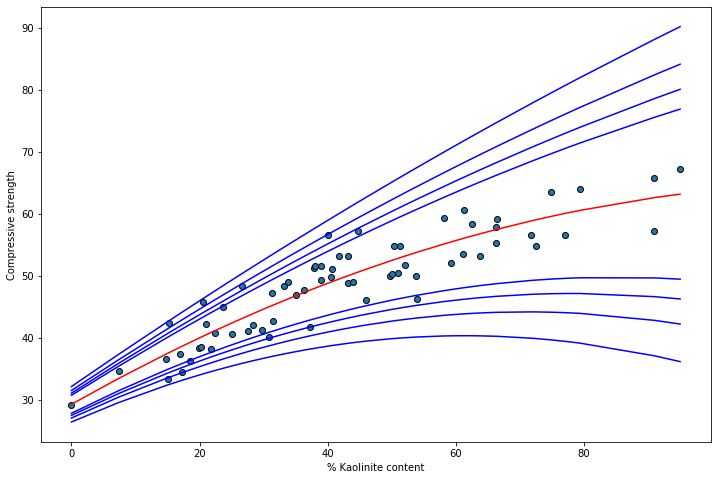

MSE: 12.724683642602642
R^2: 0.8355799295281007



In [163]:
X = data_28[['Kaolinite_content','Kaolinite_content_square']].values
y = data_28['day_28']

mod = smf.ols(formula='day_28 ~ Kaolinite_content + Kaolinite_content_square', data=data_28)
np.random.seed(2)
res = mod.fit()

conf90 = res.conf_int(alpha=0.1)
conf80 = res.conf_int(alpha=0.2)
conf70 = res.conf_int(alpha=0.3)
conf60 = res.conf_int(alpha=0.4)

# This could be generalized but degree n >= 3 leads to overfitting!
print('f(x) = {0} + {1}*x + {2}*x^2'.format(res.params[0],res.params[1],res.params[2]))
    
# Get the list of predictions obtained while validating
predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))

ax.plot(X[:,0], np.dot(X,[conf60[0][1],conf60[0][2]]) + conf60[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[0][1],conf70[0][2]]) + conf70[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[0][1],conf80[0][2]]) + conf80[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf90[0][1],conf90[0][2]]) + conf90[0][0],'b-')
ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
ax.plot(X[:,0], np.dot(X,[conf90[1][1],conf90[1][2]]) + conf90[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[1][1],conf80[1][2]]) + conf80[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[1][1],conf70[1][2]]) + conf70[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf60[1][1],conf60[1][2]]) + conf60[1][0],'b-')

ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')
plt.show()

# Metrics for the model
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(model.score(X,y)))
print()

In [61]:
data_90 = data[['Kaolinite_content', '90D']].copy()
data_90.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
data_90 = data_90.dropna()

data_90.rename(columns = {'90D' : 'day_90'}, inplace = True)

In [62]:
# Day 90
mod = smf.ols(formula='day_90 ~ Kaolinite_content + Kaolinite_content_square', data=data_90)
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.870
Method:                 Least Squares   F-statistic:                     205.0
Date:                Wed, 09 Dec 2020   Prob (F-statistic):           2.75e-27
Time:                        10:58:28   Log-Likelihood:                -157.56
No. Observations:                  62   AIC:                             321.1
Df Residuals:                      59   BIC:                             327.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.4110      1.627     17.466      0.000      25.156      31.666
Kaolinite_content            0.6896      0.073      9.500      0.000       0.544       0.835
Kaolinite_content_square    -0.0033      0.001     -4.496      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        0.073   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.964   Jarque-Bera (JB):                0.228
Skew:                           0.063   Prob(JB):                        0.892
Kurtosis:                       2.731   Cond. No.                     1.27e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.27e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

f(x) = 28.41098211053267 + 0.6895682753822635*x + -0.003263615026661602*x^2


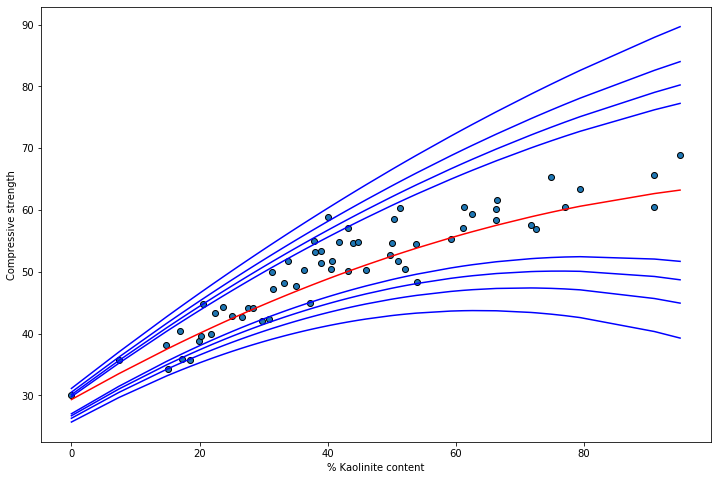

MSE: 10.517834018934327
R^2: 0.8323744207429139



In [164]:
X = data_90[['Kaolinite_content','Kaolinite_content_square']].values
y = data_90['day_90']

mod = smf.ols(formula='day_90 ~ Kaolinite_content + Kaolinite_content_square', data=data_90)
np.random.seed(2)
res = mod.fit()

conf90 = res.conf_int(alpha=0.1)
conf80 = res.conf_int(alpha=0.2)
conf70 = res.conf_int(alpha=0.3)
conf60 = res.conf_int(alpha=0.4)

# This could be generalized but degree n >= 3 leads to overfitting!
print('f(x) = {0} + {1}*x + {2}*x^2'.format(res.params[0],res.params[1],res.params[2]))
    
# Get the list of predictions obtained while validating
predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))

ax.plot(X[:,0], np.dot(X,[conf60[0][1],conf60[0][2]]) + conf60[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[0][1],conf70[0][2]]) + conf70[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[0][1],conf80[0][2]]) + conf80[0][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf90[0][1],conf90[0][2]]) + conf90[0][0],'b-')
ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
ax.plot(X[:,0], np.dot(X,[conf90[1][1],conf90[1][2]]) + conf90[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf80[1][1],conf80[1][2]]) + conf80[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf70[1][1],conf70[1][2]]) + conf70[1][0],'b-')
ax.plot(X[:,0], np.dot(X,[conf60[1][1],conf60[1][2]]) + conf60[1][0],'b-')

ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')
plt.show()

# Metrics for the model
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(model.score(X,y)))
print()

**First sight analysis:**

* We can't afford confidence intervals of such a high precission with such a lack of points, specially for high kaolinite contents.
* However, this worths a try after adding all the points from the second excel!

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/

* Linear regression with python: \
https://realpython.com/linear-regression-in-python/ 

* Confidence estimation: \
https://www.puneetarora2000.com/2020/01/data-interpretation-understanding-ols.html \
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01 \
https://www.statsmodels.org/stable/regression.html \
https://www.datarobot.com/blog/ordinary-least-squares-in-python/ \
https://online.stat.psu.edu/stat415/lesson/7/7.5 \
https://tungmphung.com/confidence-intervals-for-linear-regression-coefficients/ \
https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html

